Для Python 3.10 следующий набор версий библиотек рабочий и не падает с ошибками при выполнении данного ноутбука:

<ul>
    <li>pandas==2.0.3</li>
    <li>numpy==1.24.4</li>
    <li>statsmodels==0.14.4</li>
    <li>matplotlib==3.10.0</li>
    <li>scipy==1.10.1</li>
    <li>statsmodels==0.14.4</li>
    <li>sklearn==1.6.1</li>
    <li>arch==7.2.0</li>
</ul>


# Лекция 3
## Модели ARIMA и GARCH

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox

In [2]:
%matplotlib inline

In [3]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [5]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

## В чем суть

Будем представлять временной ряд $y_t$ в виде

$y_t = T + S + E$

где T - тренд, S - сезонная компонента, E - ошибка прогноза

Будем рассматривать разные "порождающие" модели для рядов. Интуитивно - если ряд хорошо описывается моделью, то остатки - независимые и одинаково распределенные

## Белый шум и случайные блуждания

Первая модель - которую мы рассмотрим - белый шум.

$y_t = E$

Results of Dickey-Fuller Test:
Test Statistic                 -24.032967
p-value                          0.000000
#Lags Used                       1.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64


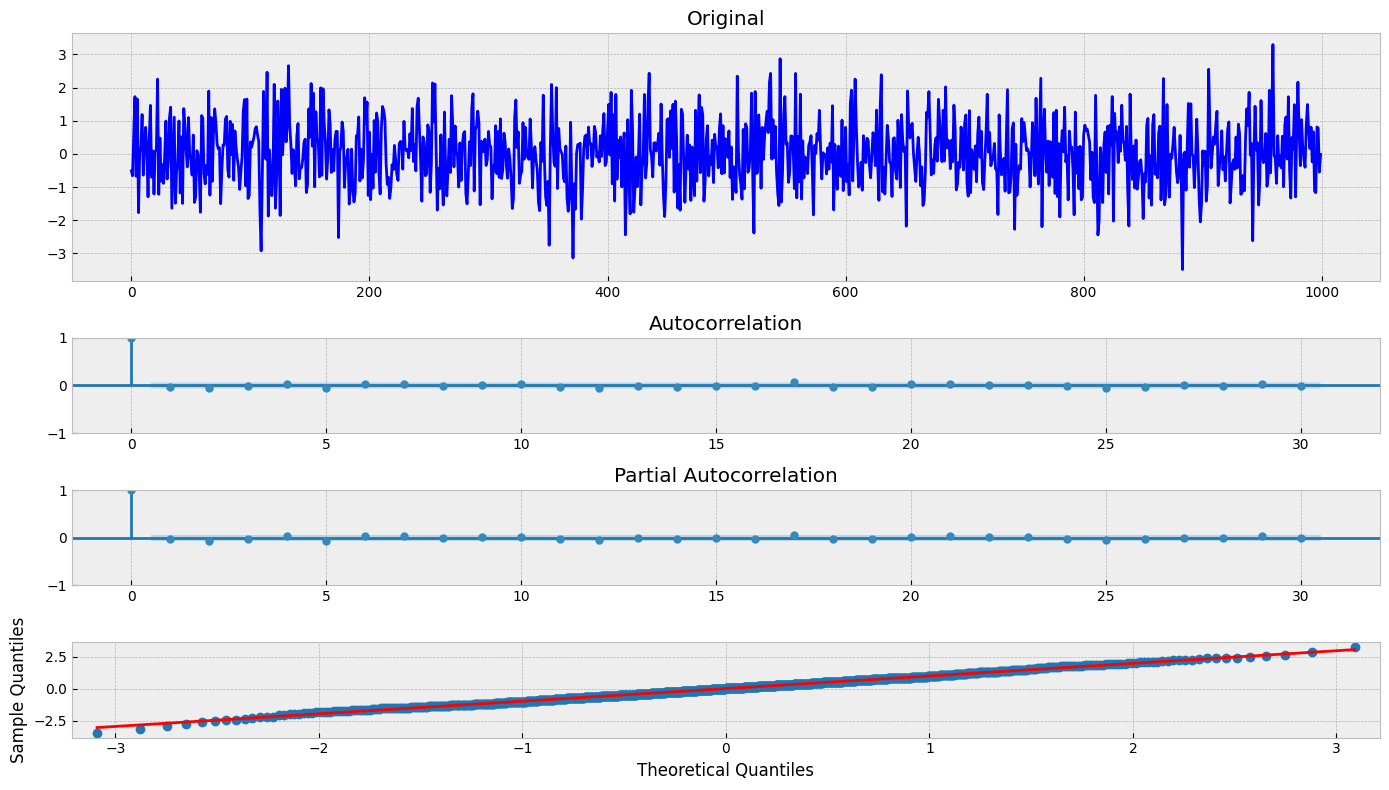

In [6]:
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

## Random Walk

### Следующая модель - это модель случайного блуждания.

$y_t = y_{t-1} + \epsilon_{t}$

где $\epsilon_{t}$ - белый шум
Особенность случайного блуждания в том, что он не стационарен, т.е. его свойства меняются со временем и предсказать его невозможно

## Практика - реализуйте процесс случайного блуждания

In [7]:
n_samples = 100

In [8]:
eps = np.random.normal(size=n_samples)
x = [0 + eps[0]]
for i in range(1, n_samples):
    x.append(x[i-1] + eps[i])

In [9]:
x = np.array(x)

Results of Dickey-Fuller Test:
Test Statistic                 -1.574619
p-value                         0.496330
#Lags Used                      0.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64


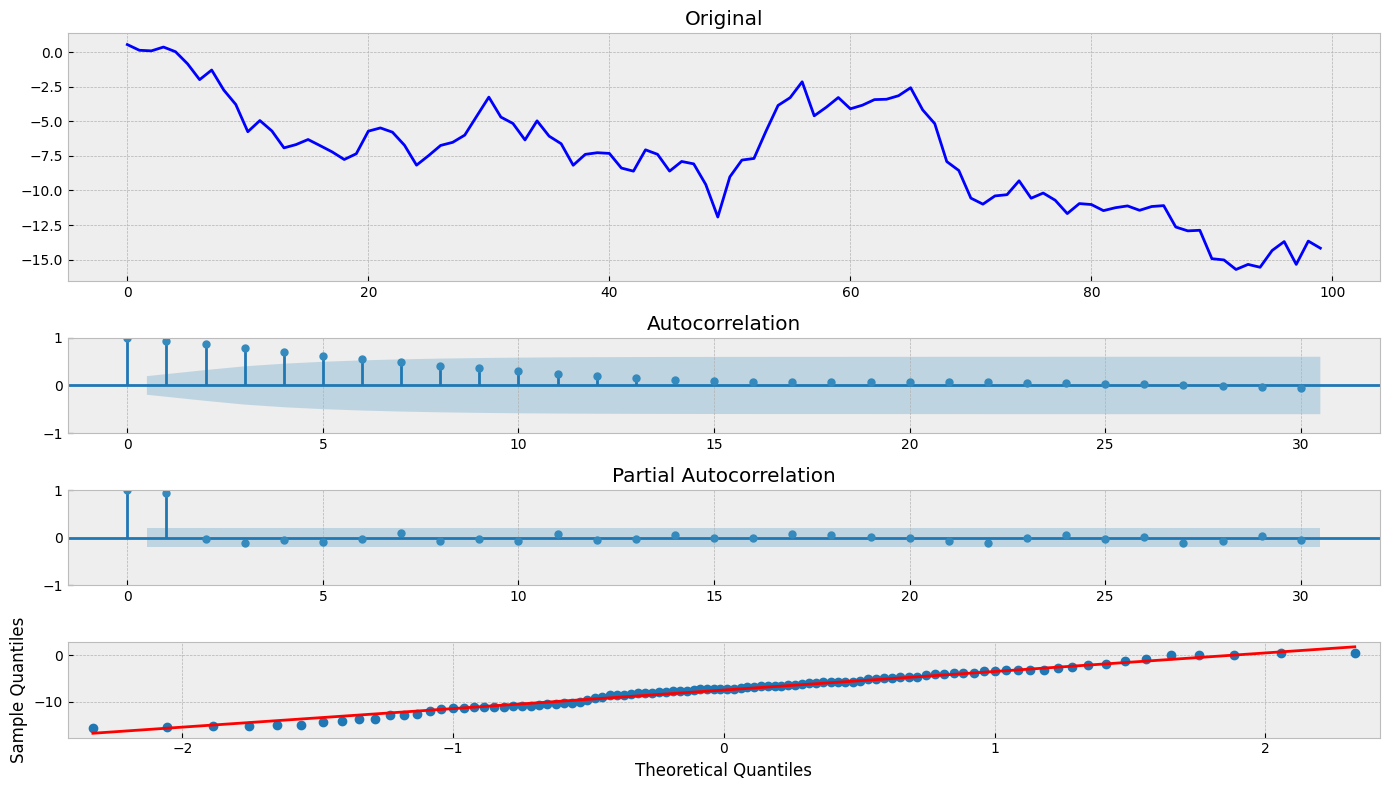

In [10]:
tsplot(x, lags=30)

In [11]:
x = np.random.normal(size=1000)
x = np.cumsum(x)
tsplot(x, lags=30)

Results of Dickey-Fuller Test:
Test Statistic                  -1.841903
p-value                          0.359865
#Lags Used                       6.000000
Number of Observations Used    993.000000
Critical Value (1%)             -3.436953
Critical Value (5%)             -2.864455
Critical Value (10%)            -2.568322
dtype: float64


Давайте проверим, подходит ли модель случайного блуждания под сгенерированные данные. Для этого надо из текущего измерения вычесть предыдущие и посмотреть остатки

Results of Dickey-Fuller Test:
Test Statistic                -1.213036e+01
p-value                        1.741632e-22
#Lags Used                     5.000000e+00
Number of Observations Used    9.930000e+02
Critical Value (1%)           -3.436953e+00
Critical Value (5%)           -2.864455e+00
Critical Value (10%)          -2.568322e+00
dtype: float64


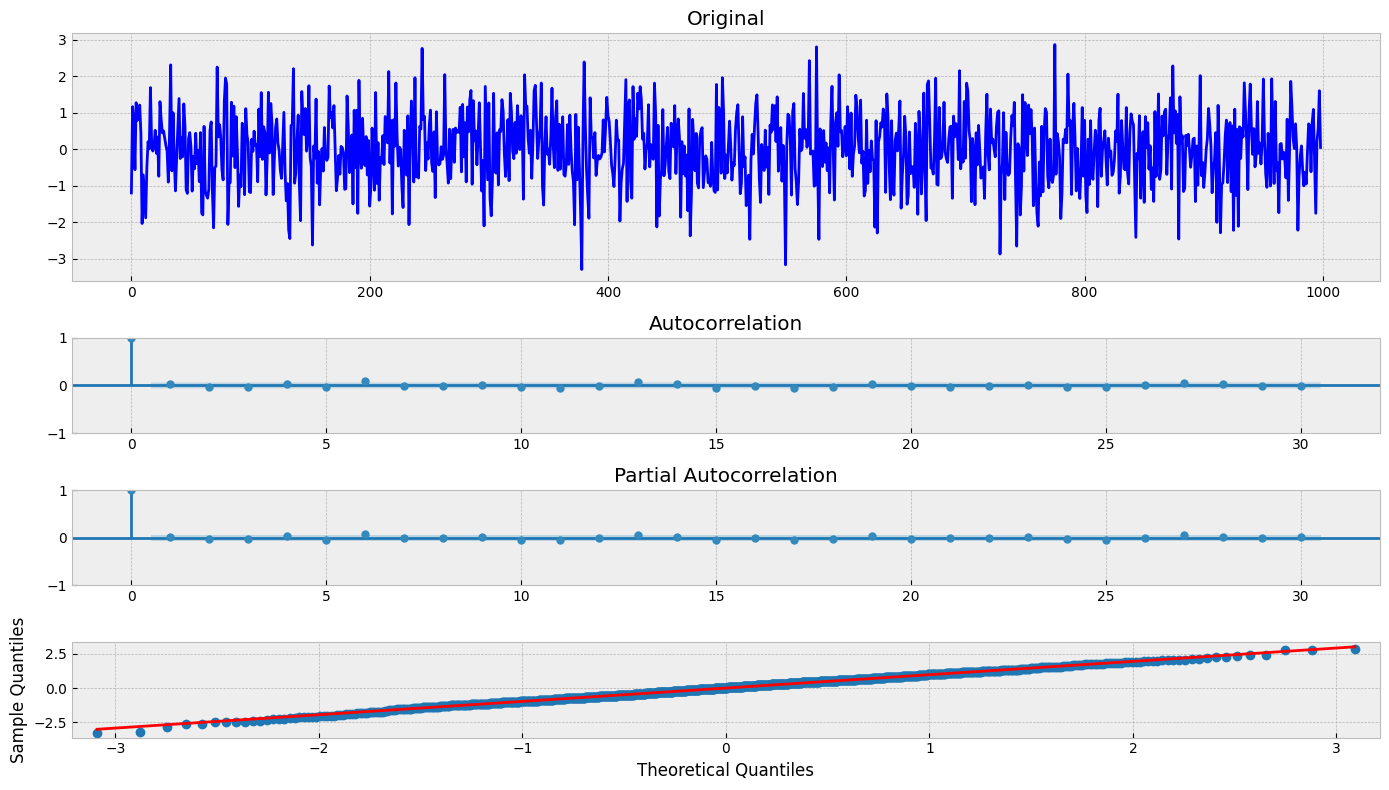

In [12]:
tsplot(np.diff(x), lags=30)

Ура! Однако для реальных данных такой модели конечно не достаточно.

# AR(p)

Авторегрессионная модель — модель временных рядов, в которой значения временного ряда в данный момент линейно зависят от предыдущих значений этого же ряда. Авторегрессионный процесс порядка p (AR(p)-процесс) определяется следующим образом

$y_t = c + \sum_{i=1}^P a_i y_{t-i} + \epsilon_t$

где $\epsilon_t$ - белый шум

Сделаем симуляцию процесса AR(1) и посмотрим, сумеет ли модель AR правильно подобрать коэффициенты

In [13]:
np.random.seed(1)
n_samples = int(1000)
a = 0.5
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
tsplot(x, lags=30)

Results of Dickey-Fuller Test:
Test Statistic                -1.877613e+01
p-value                        2.024692e-30
#Lags Used                     0.000000e+00
Number of Observations Used    9.990000e+02
Critical Value (1%)           -3.436913e+00
Critical Value (5%)           -2.864437e+00
Critical Value (10%)          -2.568313e+00
dtype: float64


In [14]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import arma_order_select_ic

In [15]:
order_selection = arma_order_select_ic(x, max_ar=30, max_ma=0, ic='aic', trend='n')
best_order = order_selection.aic_min_order[0]

mdl = AutoReg(x, lags=best_order, trend='n').fit()

true_order = 1
print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], best_order))
print('\ntrue alpha = {} | true order = {}'.format(a, true_order))


alpha estimate: 0.48076 | best lag order = 1

true alpha = 0.5 | true order = 1


In [16]:
mdl.params

array([0.48076147])

In [17]:
tsplot(mdl.resid, lags=30)

Results of Dickey-Fuller Test:
Test Statistic                 -31.856304
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64


## Практика - сделайте симуляцию процесса AR(2) с параметрами 0.6 и 0.3 и посмотрите, сумеет ли модель AR правильно подобрать коэффициенты

Results of Dickey-Fuller Test:
Test Statistic                -6.988709e+00
p-value                        7.845875e-10
#Lags Used                     1.000000e+00
Number of Observations Used    9.980000e+02
Critical Value (1%)           -3.436919e+00
Critical Value (5%)           -2.864440e+00
Critical Value (10%)          -2.568314e+00
dtype: float64


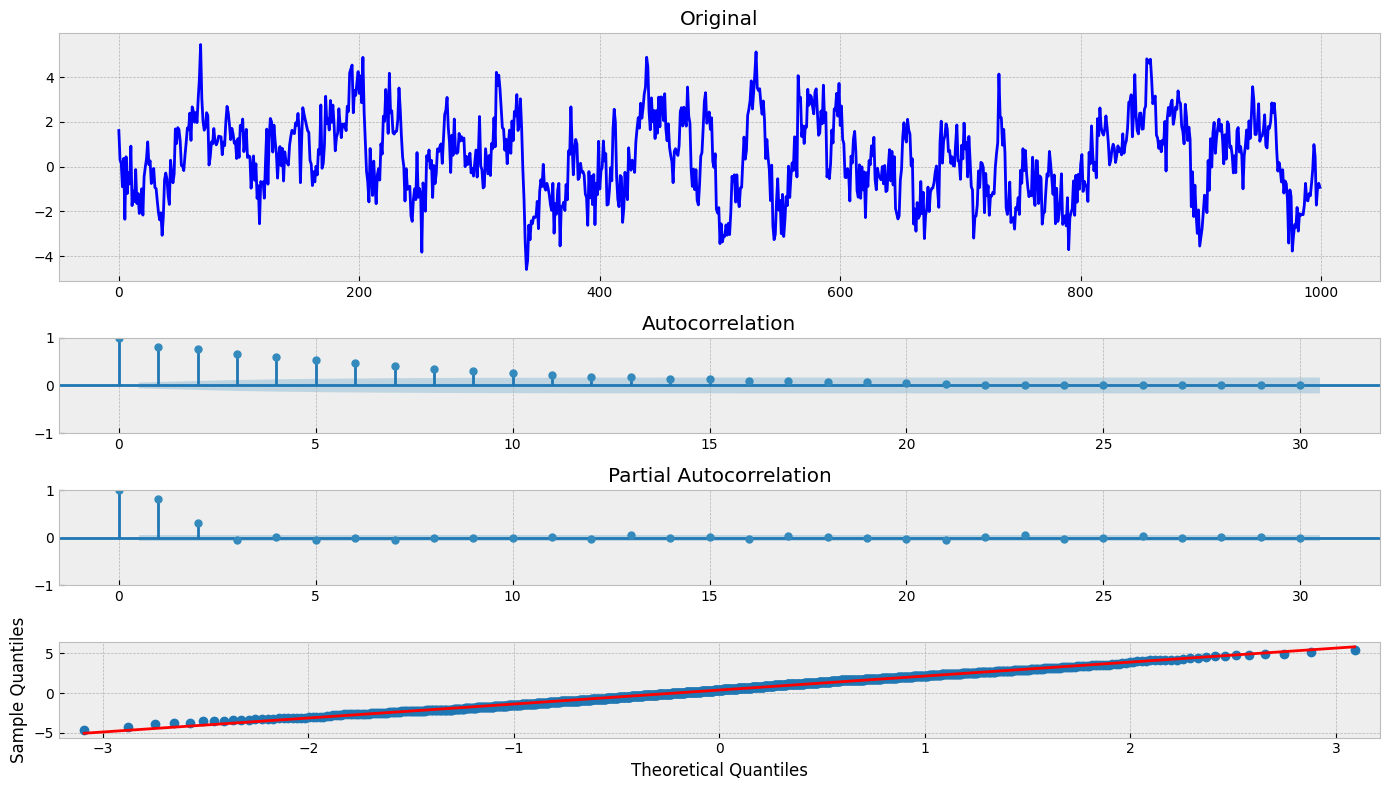

In [18]:
np.random.seed(1)
n_samples = int(1000)
a1 = 0.6
a2 = 0.3

x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a1*x[t-1] + a2*x[t-2] + w[t]
    
tsplot(x, lags=30)

In [19]:
mdl = AutoReg(x, lags=3, trend='n').fit()

print('\nalpha estimate: {}'.format(mdl.params))


alpha estimate: [ 0.57237228  0.34300155 -0.0433057 ]


Results of Dickey-Fuller Test:
Test Statistic                 -31.609276
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    996.000000
Critical Value (1%)             -3.436933
Critical Value (5%)             -2.864446
Critical Value (10%)            -2.568317
dtype: float64


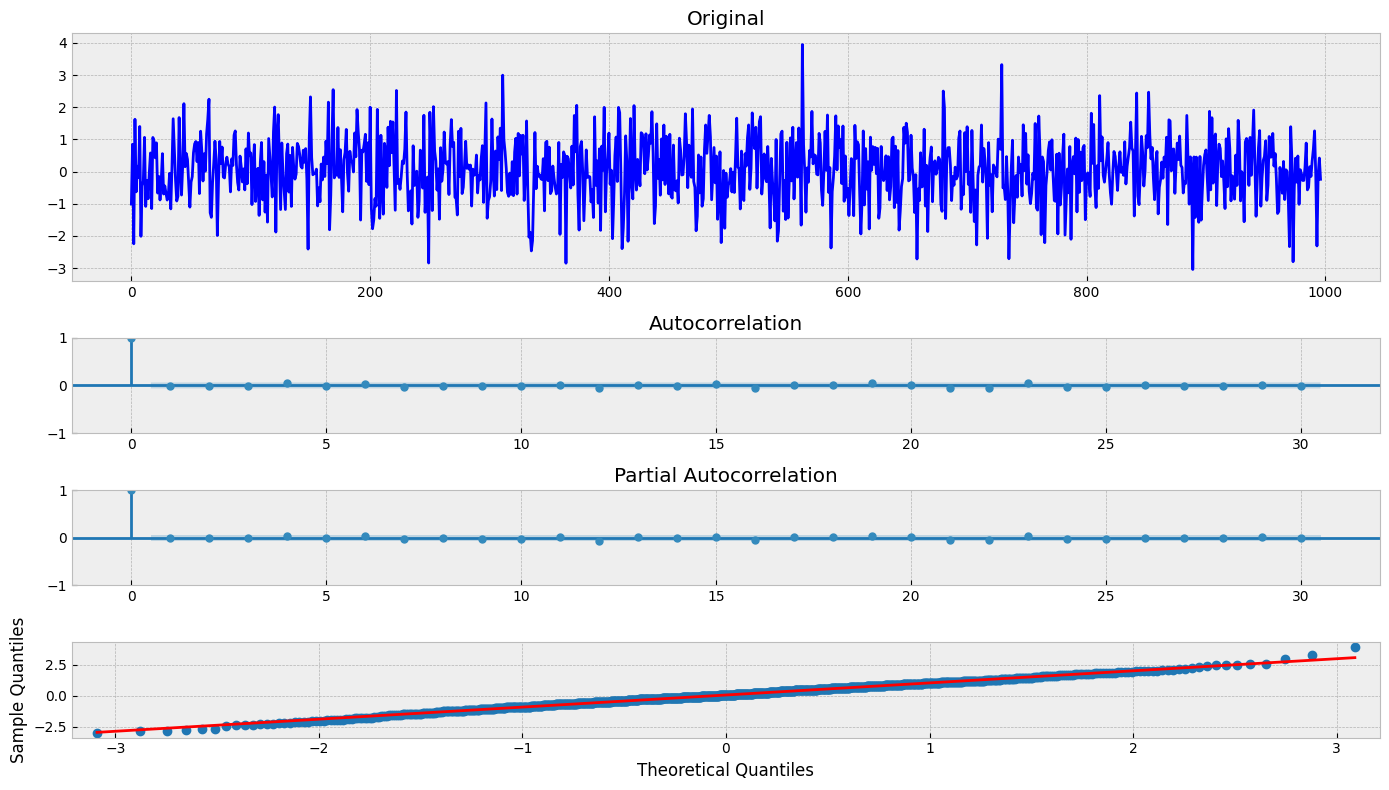

In [20]:
tsplot(mdl.resid, lags=30)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


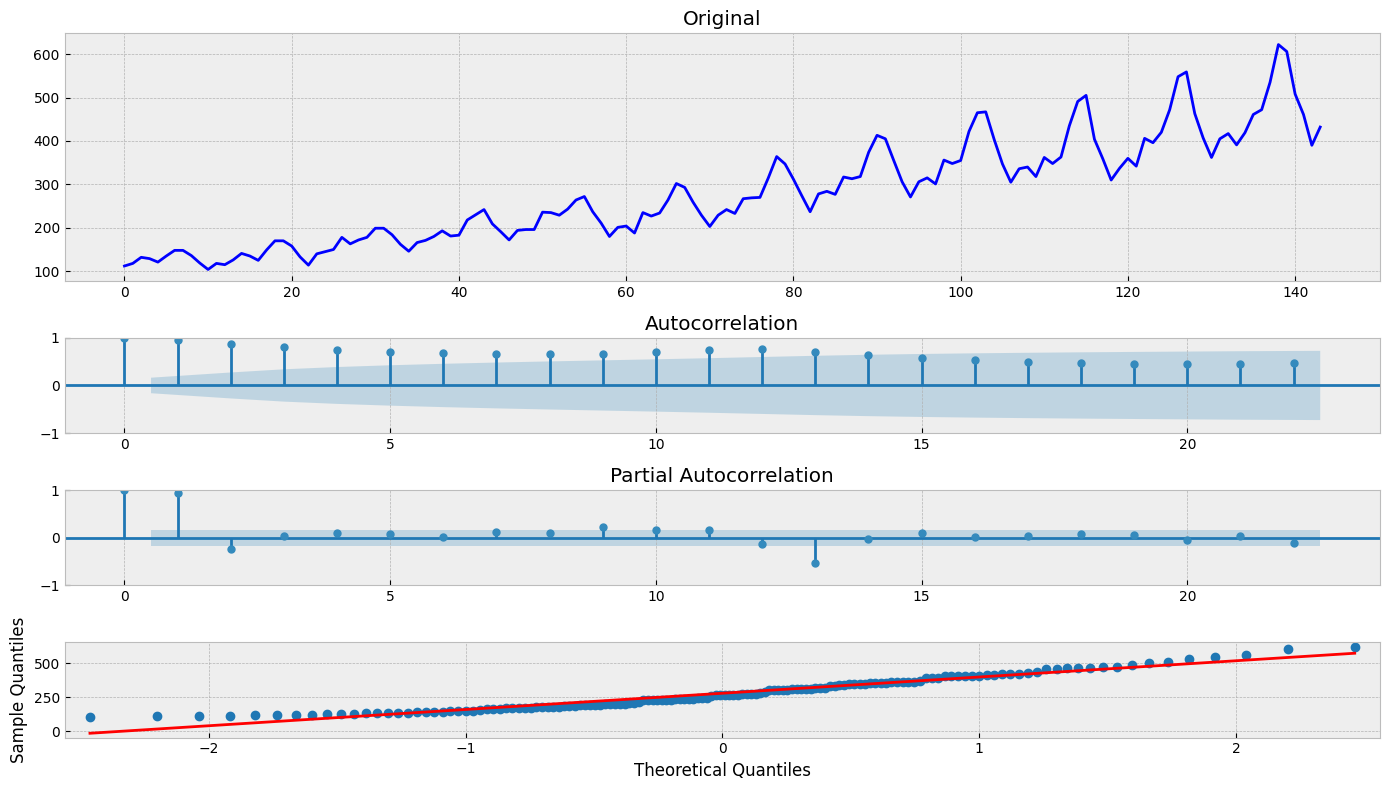

In [21]:
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']
tsplot(series)

In [22]:
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']
series = boxcox(series, 0)

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


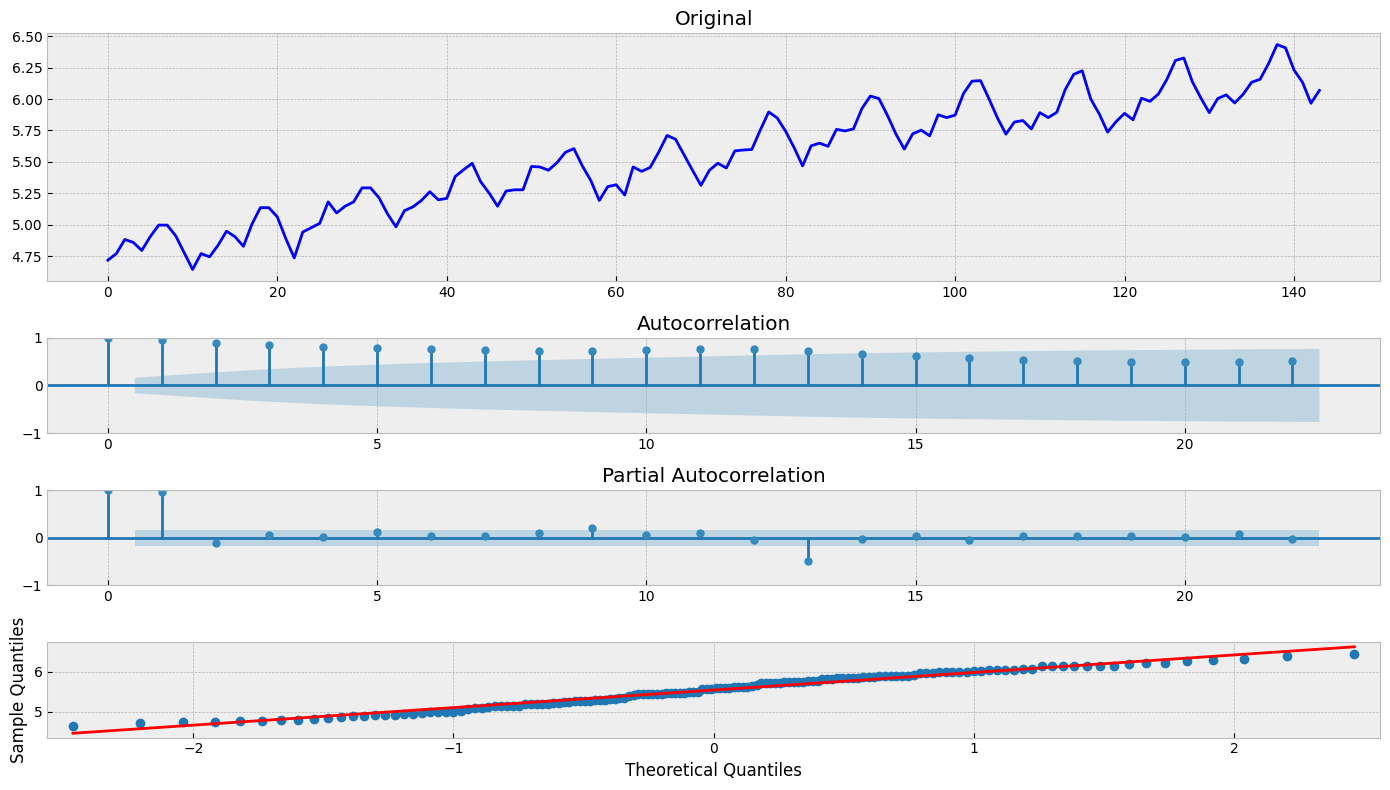

In [23]:
tsplot(series)

In [24]:
order_selection = arma_order_select_ic(series, max_ar=30, ic='aic', trend='n')
selected_order = order_selection.aic_min_order[0]

mdl = AutoReg(series, lags=selected_order, trend='n').fit()

print("Selected AR order:", selected_order)
print("Estimated parameters:")
print(mdl.params)

Selected AR order: 18
Estimated parameters:
[ 0.68515369  0.14568251 -0.07072446 -0.01551122  0.19021639 -0.14334347
  0.10276578 -0.14653156  0.20218814 -0.15036946  0.15064593  0.74315624
 -0.3858979  -0.35941132  0.21669962 -0.13679483  0.00083421 -0.02559196]


In [25]:
tsplot(mdl.resid)

Results of Dickey-Fuller Test:
Test Statistic                -1.123942e+01
p-value                        1.822735e-20
#Lags Used                     0.000000e+00
Number of Observations Used    1.250000e+02
Critical Value (1%)           -3.483779e+00
Critical Value (5%)           -2.884954e+00
Critical Value (10%)          -2.579257e+00
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


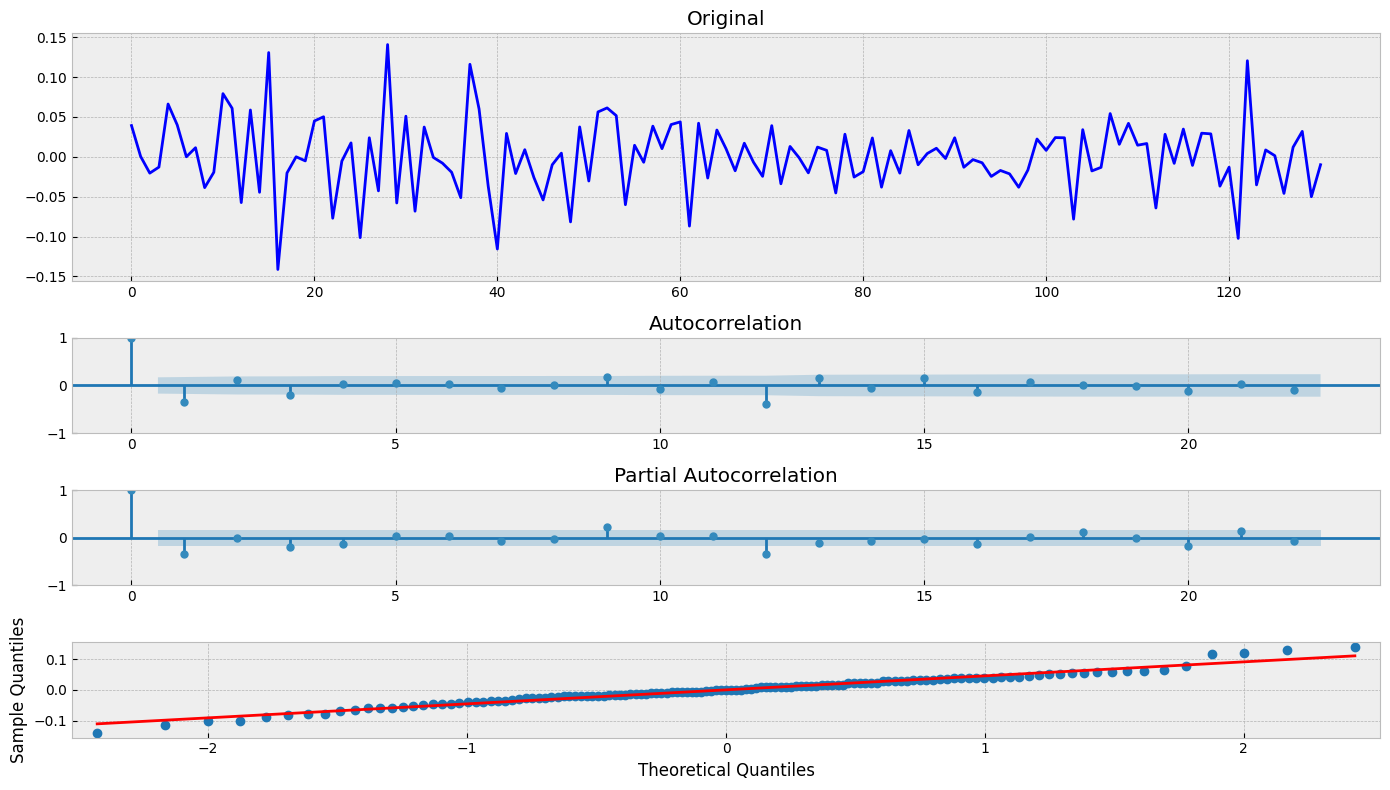

In [26]:
series_diffed = np.diff(series)
series_diffed = series_diffed[12:] - series_diffed[:-12]
tsplot(series_diffed)

## MA(q)
В настоящий момент будем говорить про модель MA(q) - как про модель авторегресии на случайном шуме

$y_t = \sum_{j=0}^{Q} b_j \epsilon_{t-j}$

## ARMA(p,q)

Модель ARMA(p, q) представляет собой соединение двух моделей:
- AR(P) - авторегрессии на знанениях временного ряда
- MA(q) - авторегрессии на ошибках первой

AR(p) пытается предсказать "значение" временного ряда, а MA(q) пытается поймать шоковые явления, наблюдаемые в оставшемся случайном шуме.

$y_t = \sum_{i=1}^P a_i x_{t-i} + \sum_{i=1}^Q b_i \epsilon_{t-i} + \epsilon_t + c$

Сделаем симуляцию процесса ARMA

In [27]:
from statsmodels.tsa.arima.model import ARIMA

In [28]:
max_lag = 30

n = int(5000)
burn = int(n/10)

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=max_lag)

mdl = ARIMA(arma22, order=(2, 0, 2), trend='n').fit()
print(mdl.summary())

Results of Dickey-Fuller Test:
Test Statistic                -1.789014e+01
p-value                        2.979789e-30
#Lags Used                     1.500000e+01
Number of Observations Used    4.984000e+03
Critical Value (1%)           -3.431663e+00
Critical Value (5%)           -2.862120e+00
Critical Value (10%)          -2.567079e+00
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5000
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7105.938
Date:                Thu, 10 Apr 2025   AIC                          14221.876
Time:                        23:47:46   BIC                          14254.462
Sample:                             0   HQIC                         14233.297
                               - 5000                                         
Covariance Type:                  opg                                         
              

In [29]:
from statsmodels.graphics.tsaplots import plot_predict

In [30]:
with plt.style.context(style='bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plot_predict(mdl, start=4900, end=5100, ax=ax)

In [31]:
mdl.aic

14221.876207191497

p, q - гипер параметры => их можно подбирать. Как выбрать лучшие? AIC - Информационный критерий Акаике

## Практика! Реализуйте подбор гиперпараметров модели
Информационный критерий живет в вовзращаемом значении fit (у ARMA), чем меньше - тем лучше модель

In [32]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        try:
            tmp_mdl = ARIMA(arma22, order=(i, 0, j), trend='n').fit()
            tmp_aic = tmp_mdl.aic
            print('aic: {:6.5f} | order: {}'.format(tmp_aic, (i, j)))
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 17929.09107 | order: (0, 0)
aic: 14516.60147 | order: (0, 1)
aic: 14439.68565 | order: (0, 2)
aic: 14287.46235 | order: (0, 3)
aic: 14236.15930 | order: (0, 4)
aic: 16695.16238 | order: (1, 0)
aic: 14470.93086 | order: (1, 1)
aic: 14388.33861 | order: (1, 2)
aic: 14249.80330 | order: (1, 3)
aic: 14238.01891 | order: (1, 4)
aic: 15220.00838 | order: (2, 0)
aic: 14244.17036 | order: (2, 1)
aic: 14221.87621 | order: (2, 2)
aic: 14221.79240 | order: (2, 3)
aic: 14222.40905 | order: (2, 4)
aic: 14876.89571 | order: (3, 0)
aic: 14221.82897 | order: (3, 1)
aic: 14222.67878 | order: (3, 2)
aic: 14221.50760 | order: (3, 3)
aic: 14223.50809 | order: (3, 4)
aic: 14676.45381 | order: (4, 0)
aic: 14221.86156 | order: (4, 1)
aic: 14225.48332 | order: (4, 2)
aic: 14224.69982 | order: (4, 3)
aic: 14225.04015 | order: (4, 4)
aic: 14221.50760 | order: (3, 3)


Применим модель ARMA к нашей TS

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


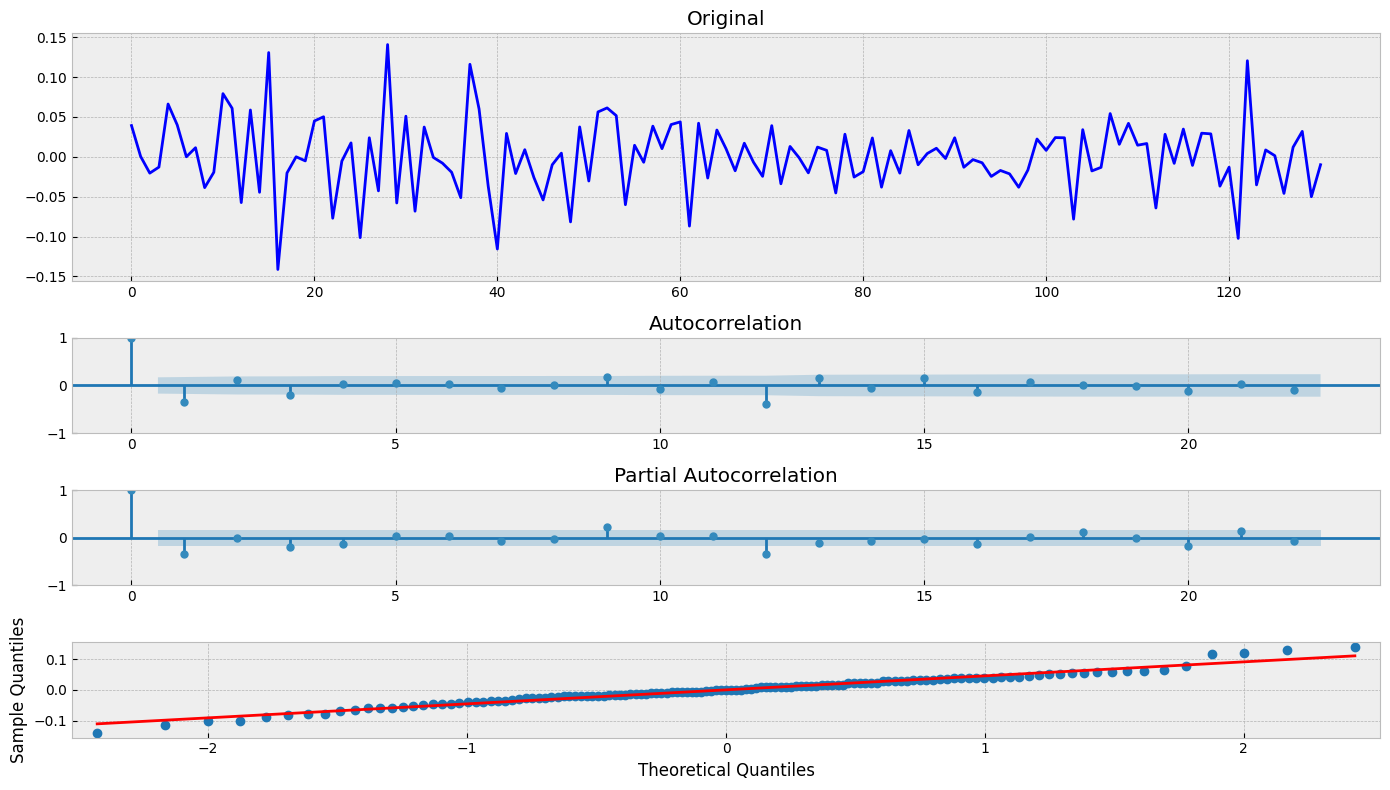

In [33]:
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']
series = boxcox(series, 0)
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]
tsplot(series)

In [34]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        try:
            tmp_mdl = ARIMA(series, order=(i, 0, j), trend='n').fit()
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: -458.15890 | order: (3, 3)


Results of Dickey-Fuller Test:
Test Statistic                  -4.916565
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


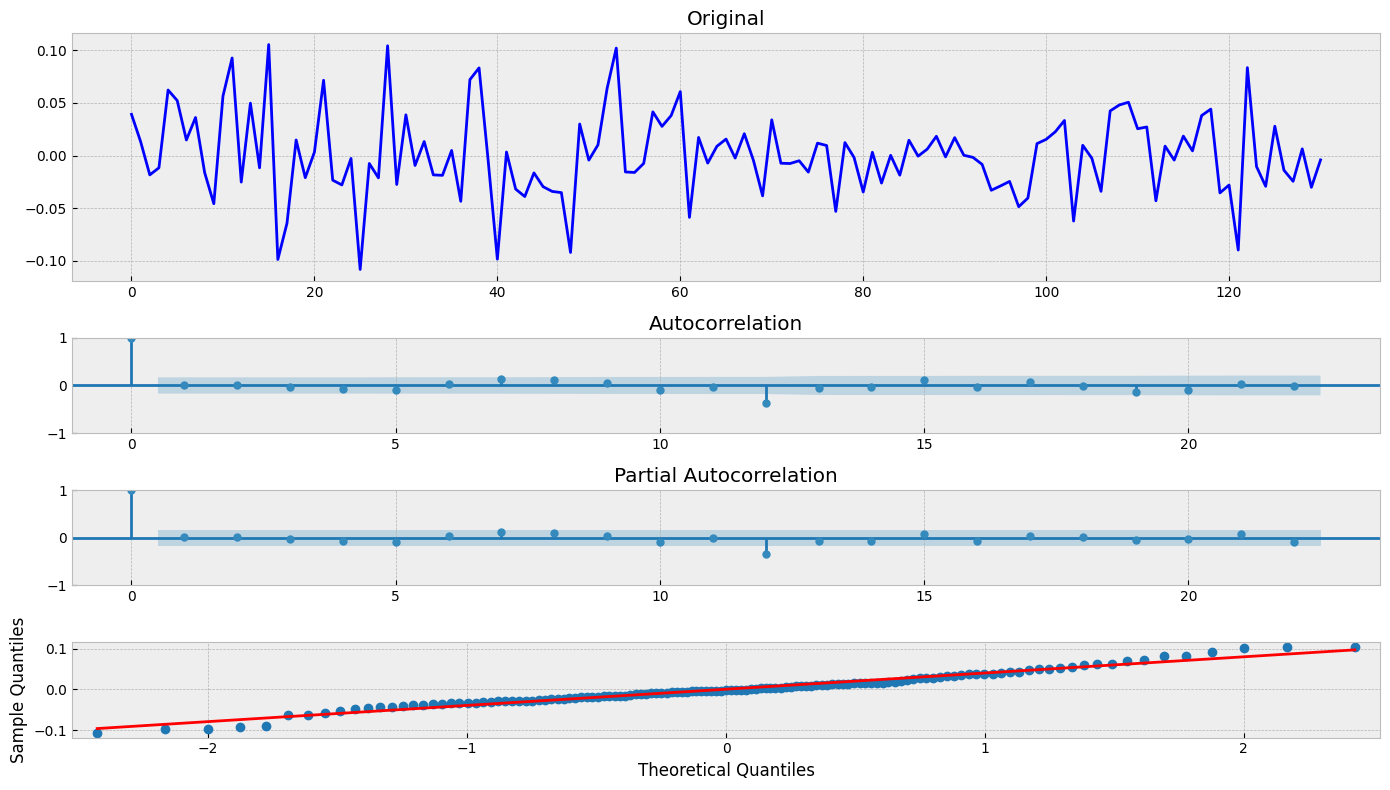

In [35]:
mdl = ARIMA(series, order=(3, 0, 3), trend='n').fit()
tsplot(mdl.resid)

Хотя по критериям модель выглядит "более-менее" нормально, она все еще не похожа на случайный шум.

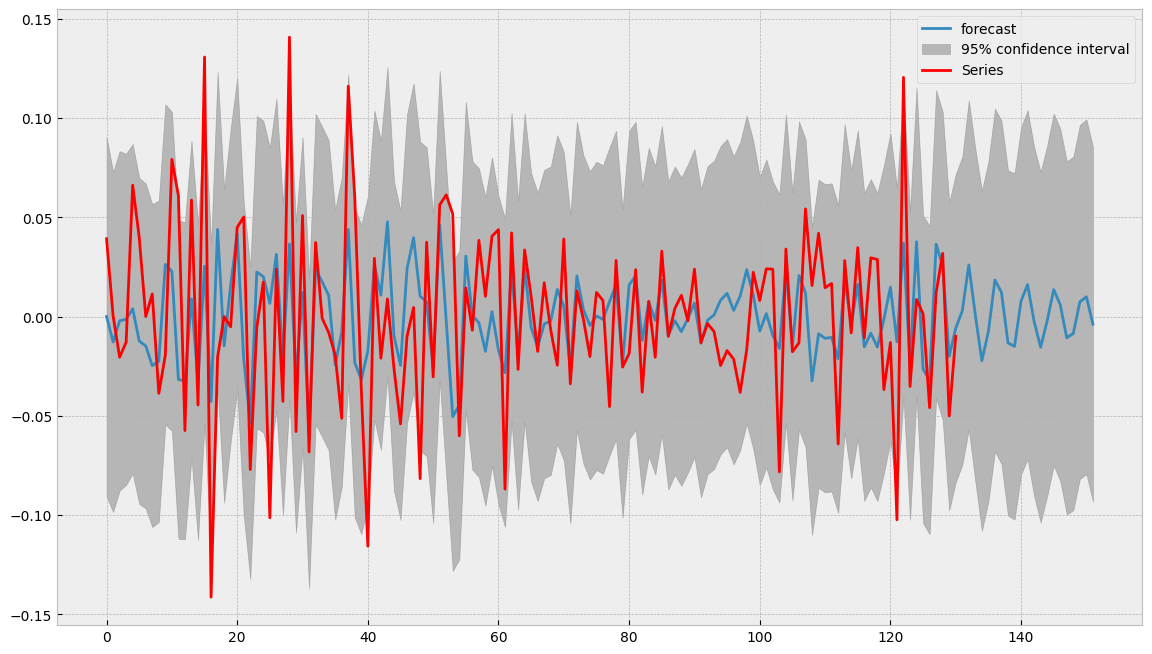

In [36]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plot_predict(mdl, 0, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

## ARIMA (p,d,q)

ARIMA - естественное расширение модели ARMA. Как мы уже хорошо знаем - многие временные ряды не стационарны, но они могут такими стать в результате операции дифференцирования. В модели ARIMA "дифференцирование" (в количестве d-раз) вносится в саму модель


$\delta^p y_t = c + \sum_{i=1}^p a_i \delta^d y_{t-i} + \sum_{j=1}^q b_j \epsilon_{t-j} + \epsilon_t$

aic: 1342.39052 | order: (4, 1, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -4.820118
p-value                          0.000050
#Lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
Critical Value (10%)            -2.578864
dtype: float64


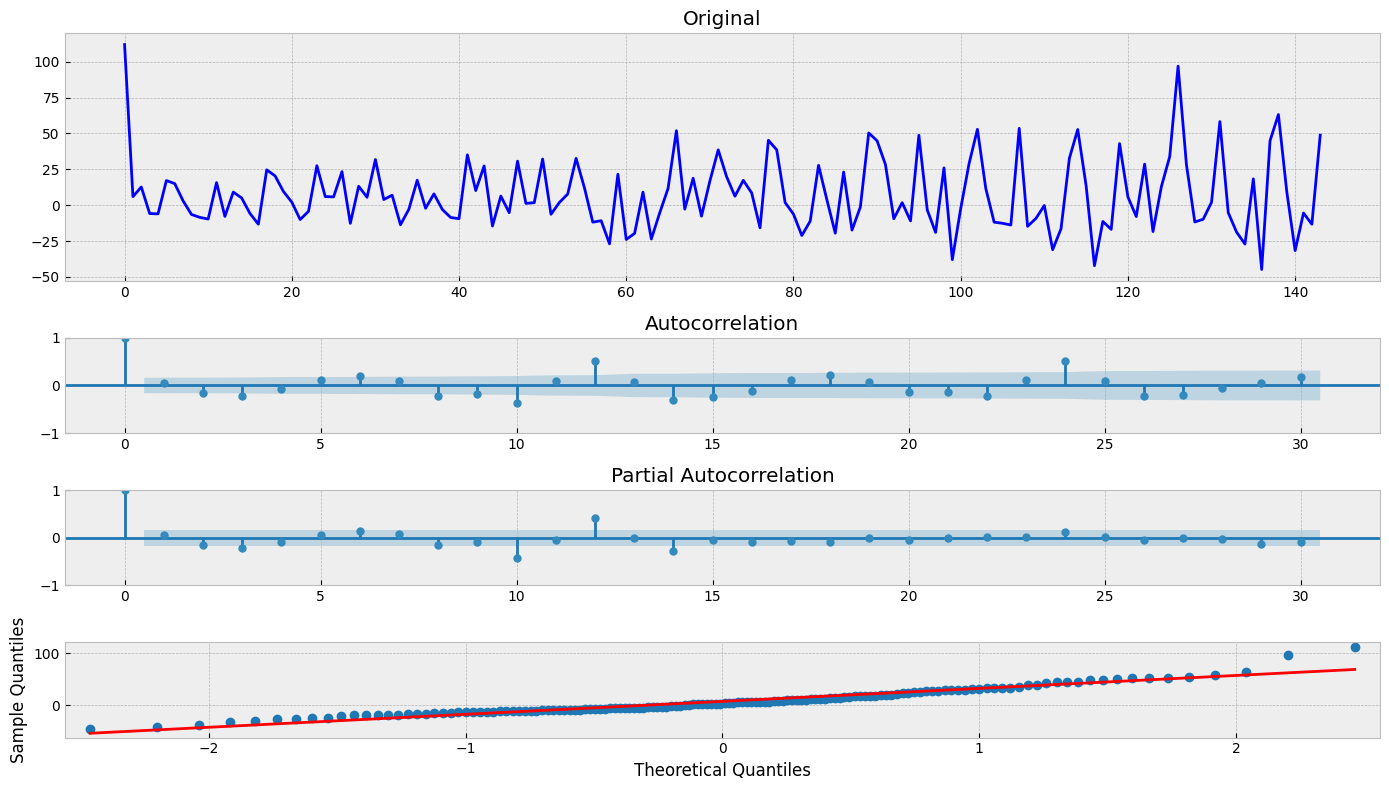

In [37]:
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']

best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = ARIMA(series, order=(i, d, j), trend='n').fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

tsplot(best_mdl.resid, lags=30)

In [38]:
best_mdl

In [39]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plot_predict(best_mdl, 1, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

Другие вариации для класса ARMA:
- SARIMA - арима с учетом сезонности
- ARIMAX/SARIMAX

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


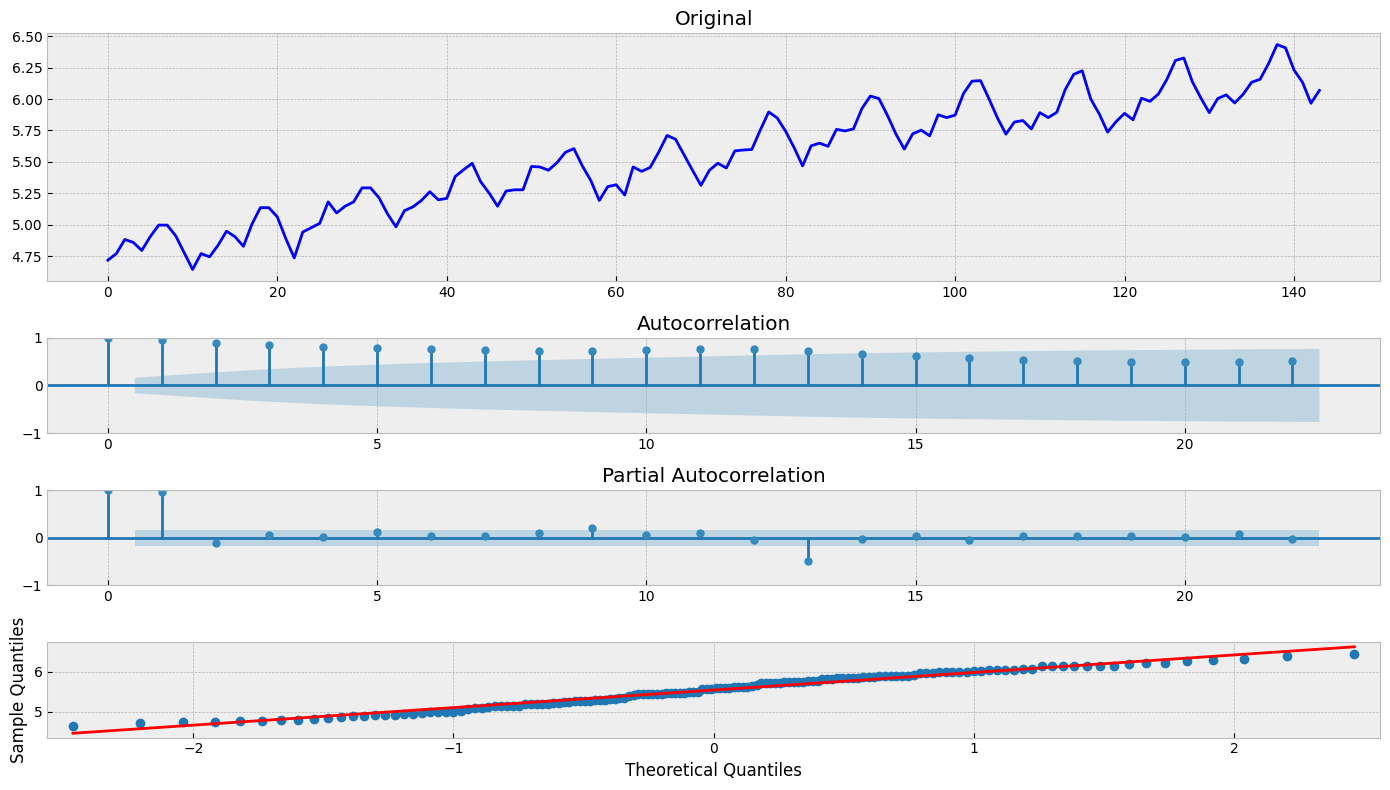

In [40]:
series = pd.read_csv("Series/international-airline-passengers.csv")['Count']
series = boxcox(series, 0)
tsplot(series)

aic: -293.00700 | order: (4, 1, 4)
Results of Dickey-Fuller Test:
Test Statistic                  -3.624853
p-value                          0.005303
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


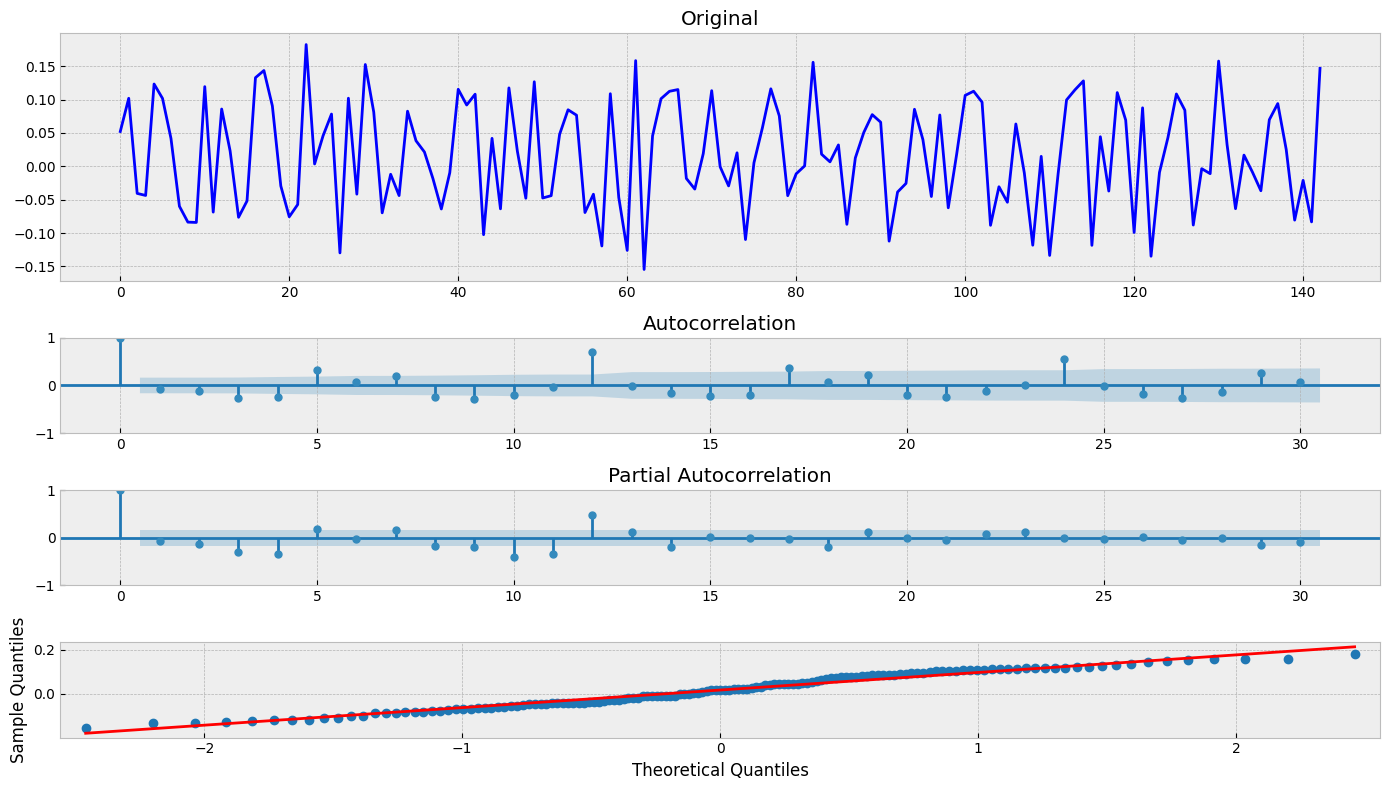

In [41]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = ARIMA(series, order=(i, d, j), trend='n').fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

tsplot(best_mdl.resid[1:], lags=30)

## ARCH

AutoRegressive Conditional Heteroscedasticity - пытаемся объяснить дисперсию в ряде через предыдущие значения (применяя к ним AR)

Пусть временной ряд представляется в таком виде:

$u_t = \epsilon_t * \sqrt{\alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2}$

Тогда условная дисперсия ряда будет равна

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2$

Получили модель ARCH(q) условной дисперсии. Требуем, чтобы все коэффициенты были больше 0 (иначе может получится отрицательная дисперсия)

In [42]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = 5.5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

Results of Dickey-Fuller Test:
Test Statistic                 -31.510128
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


## GARCH

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

In [43]:
from arch import arch_model

## Практика! Реализуйте процесс GARCH, нарисуйте его график, примените к нему модель ARIMA и посмотрите на график остатков

In [44]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

tsplot(eps, lags=30)

Results of Dickey-Fuller Test:
Test Statistic                  -96.275609
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    9999.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


In [45]:
am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 13129.794114888451
Iteration:     10,   Func. Count:     62,   Neg. LLF: 12237.31278163297
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12237.303267319116
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Thu, Apr 10 2025   Df Residuals:                     9999
Time:        

# Продолжаем анализировать полеты

Применим ARIMA к нашему временному ряду

In [46]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = ARIMA(series, order=(i, d, j), trend='n').fit()
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

aic: -293.00700 | order: (4, 1, 4)


In [47]:
tsplot(mdl.resid[1:])

Results of Dickey-Fuller Test:
Test Statistic                  -3.624853
p-value                          0.005303
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


Применим GARCH

In [48]:
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]

In [49]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 4
o_ = 1
q_ = 4

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

/usr/local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002086. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:                229.104
Distribution:      Standardized Student's t   AIC:                          -434.208
Method:                  Maximum Likelihood   BIC:                          -399.706
                                              No. Observations:                  131
Date:                      Thu, Apr 10 2025   Df Residuals:                      130
Time:                              23:49:39   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


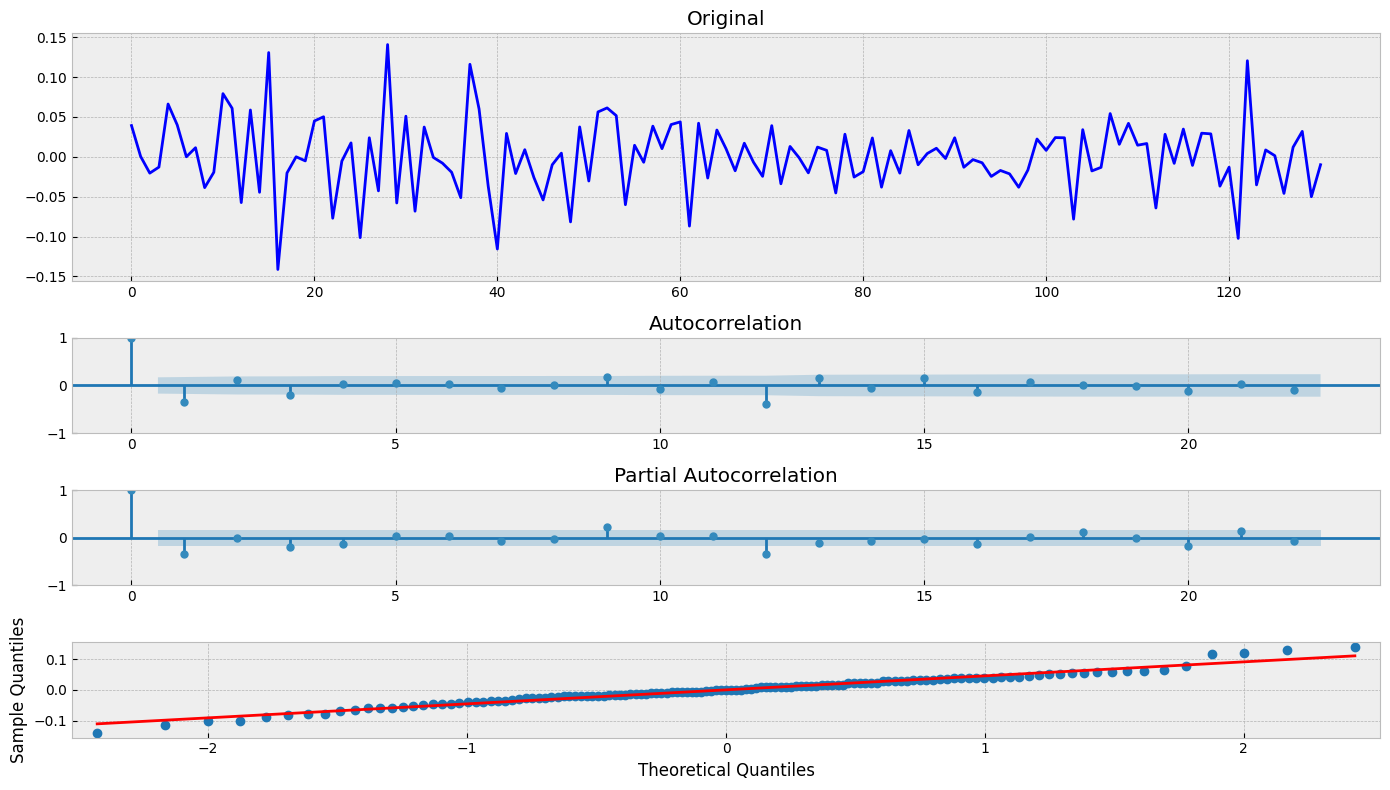

In [50]:
tsplot(res.resid)

## Проведем анализ для monthly-boston-armed-robberies-j

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


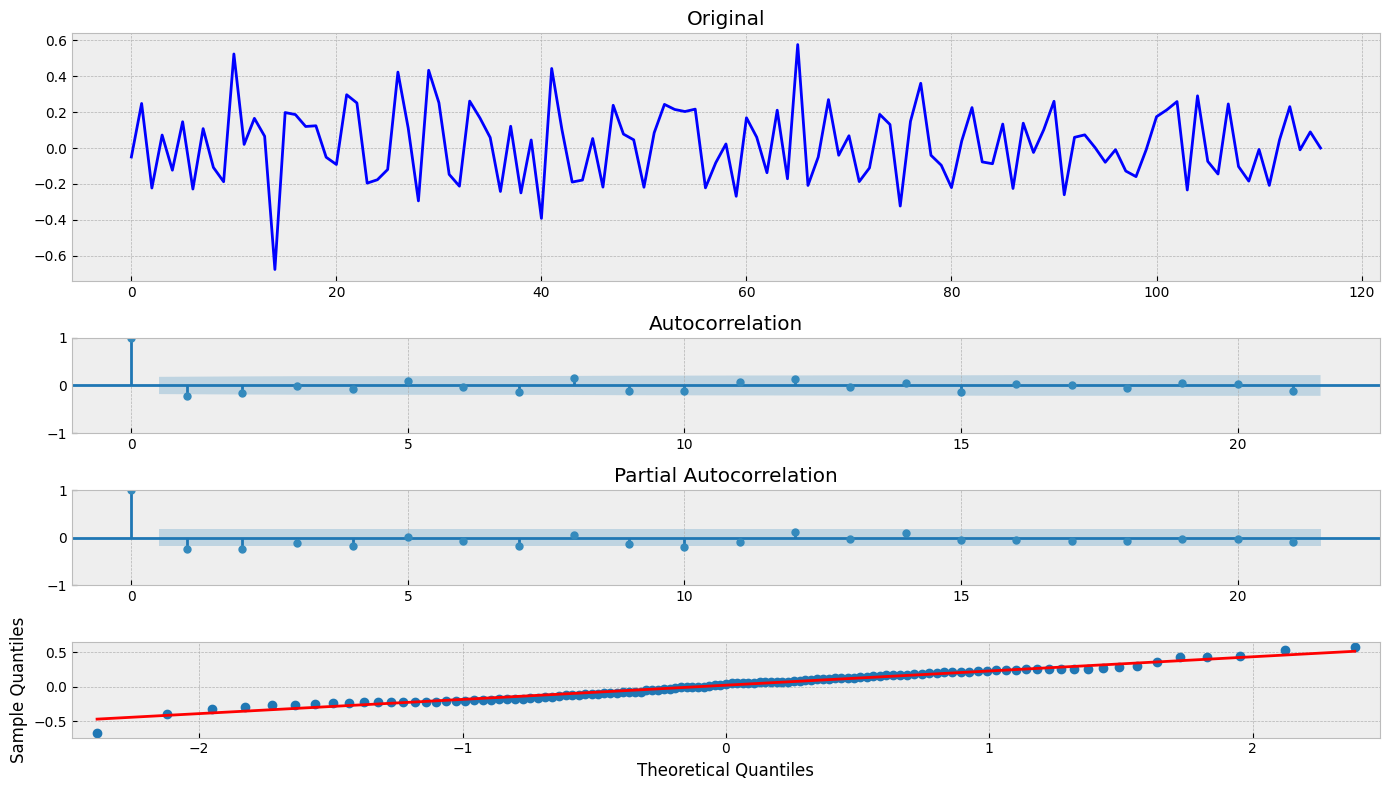

In [51]:
new_series = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")["Count"].values.astype('float64')
new_series = boxcox(new_series, 0)
new_series = new_series[1:] - new_series[:-1]
tsplot(new_series)

In [52]:
aic, order, mdl = _get_best_model(new_series)

aic: -458.15890 | order: (3, 0, 3)


Results of Dickey-Fuller Test:
Test Statistic                  -4.916565
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


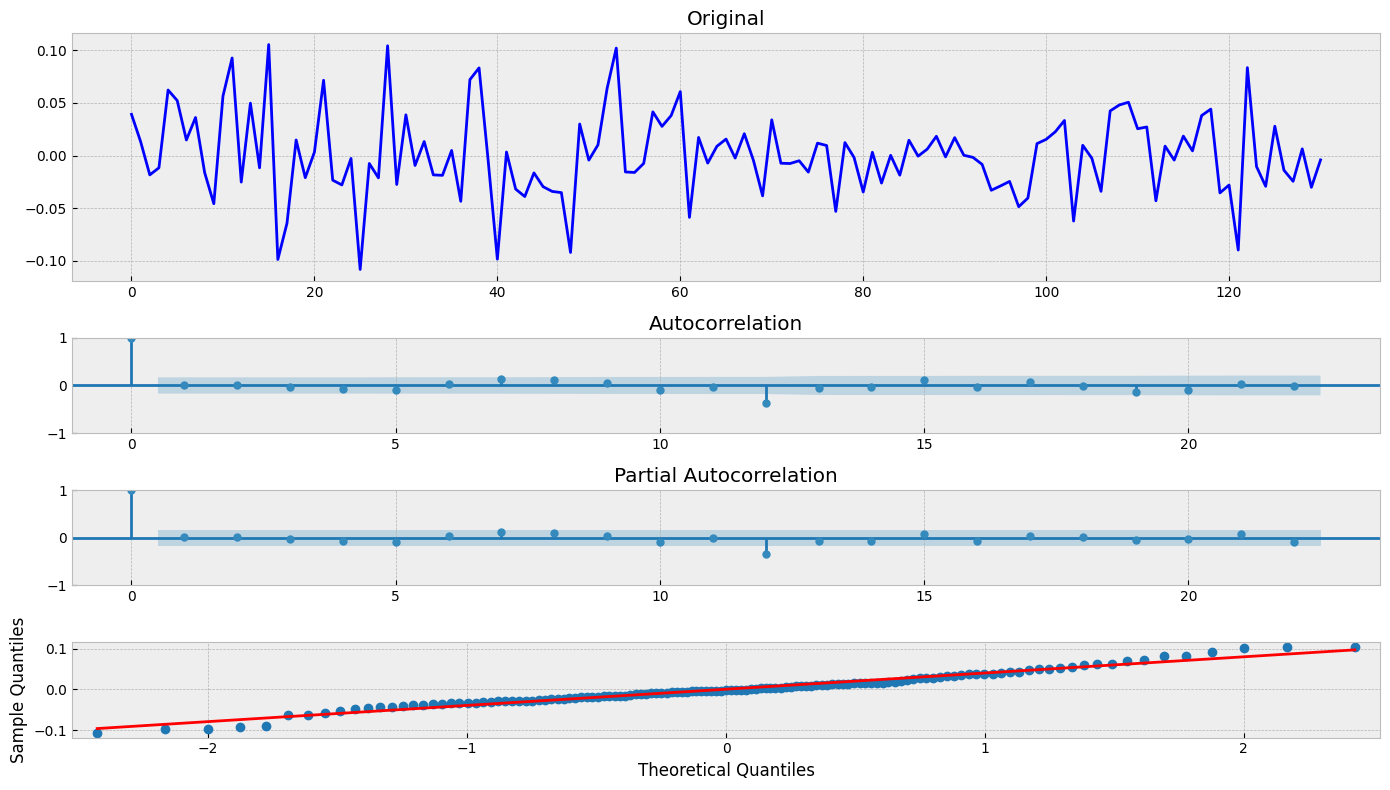

In [53]:
tsplot(mdl.resid)

In [54]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(new_series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     59,   Neg. LLF: -19.68434844081424
Iteration:     10,   Func. Count:    110,   Neg. LLF: -20.020498781817285
Iteration:     15,   Func. Count:    170,   Neg. LLF: -20.14819307990281
Iteration:     20,   Func. Count:    222,   Neg. LLF: -20.08968223373598
Iteration:     25,   Func. Count:    273,   Neg. LLF: -20.40333227226857
Iteration:     30,   Func. Count:    331,   Neg. LLF: 5.128723426854619
Iteration:     35,   Func. Count:    384,   Neg. LLF: 30529.118557310387
Optimization terminated successfully    (Exit mode 0)
            Current function value: -20.610172620174243
            Iterations: 39
            Function evaluations: 403
            Gradient evaluations: 36
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:            

/usr/local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.04251. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


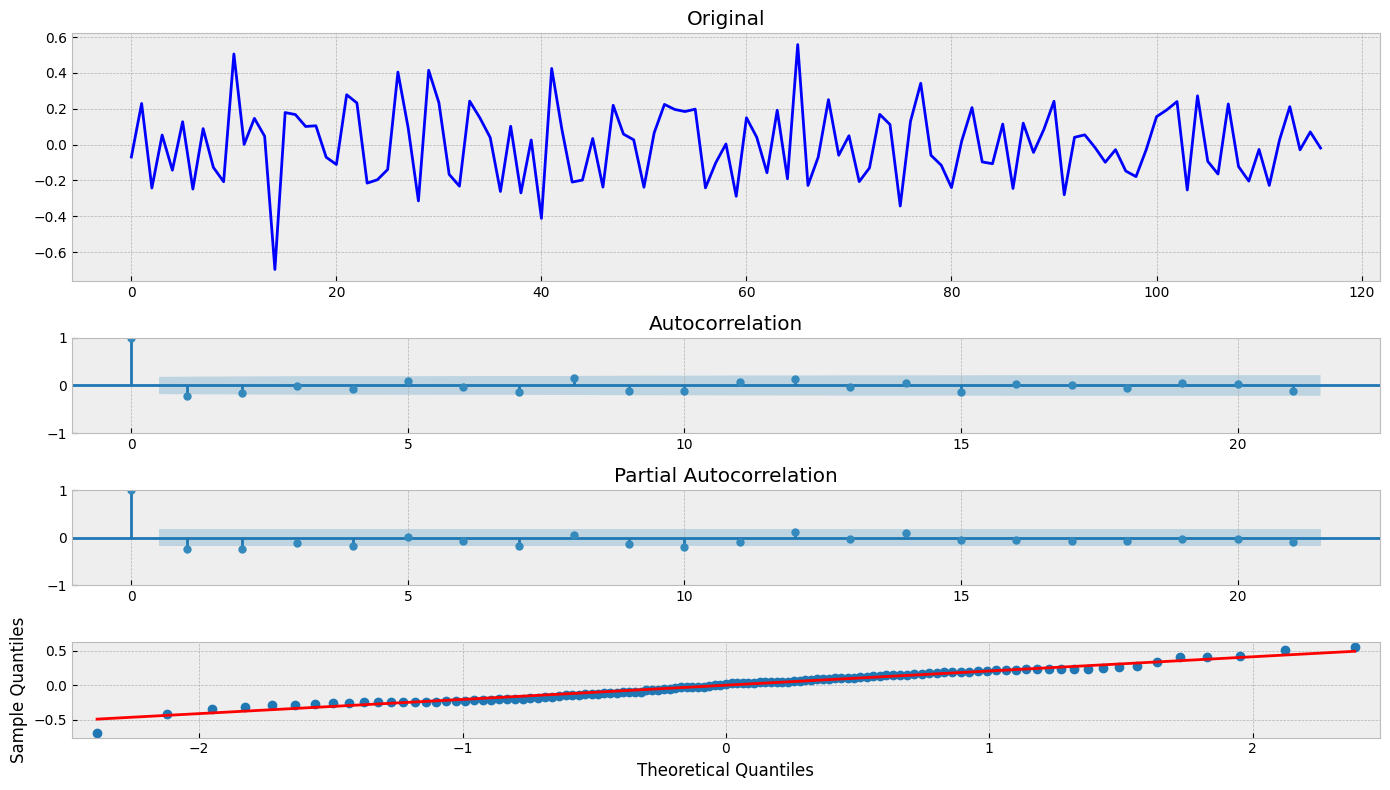

In [55]:
tsplot(res.resid)

## По простому

Такой подход является не совсем корректным (для прогнозирования свойств ВР), но он часто позволяет получать неплохие результаты в сжатые сроки

Генерируем большое количество фичей для нашего временного ряда

In [56]:
series = pd.read_csv("Series/international-airline-passengers.csv")

In [57]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [58]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

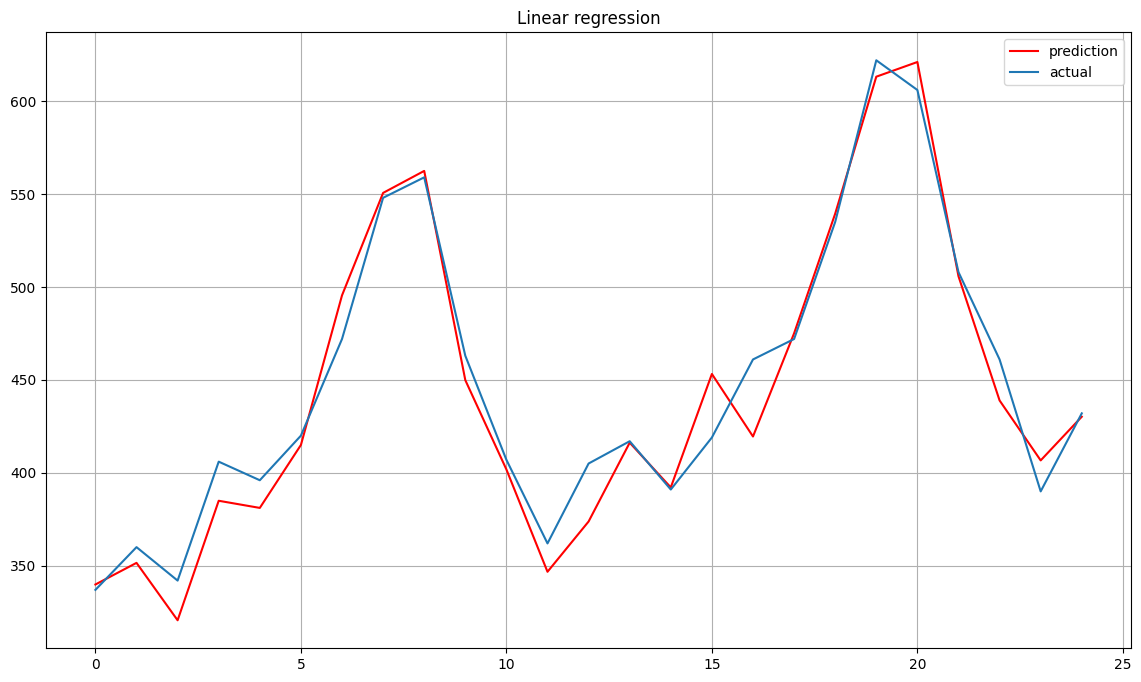

In [59]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

# Домашнее задание
- Выберите ряд и постройте его модель ARIMA/GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

## Полезная информация
- https://people.duke.edu/~rnau/411home.htm
- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276
- http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016